In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d mrinath/pneumonia

 99% 1.17G/1.17G [00:16<00:00, 134MB/s]
100% 1.17G/1.17G [00:16<00:00, 77.3MB/s]


In [ ]:
import zipfile
zf = "/content/pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/dataset/cnn/pneumonia/folders/train'
test_path = '/content/dataset/cnn/pneumonia/folders/test'
valid_path = '/content/dataset/cnn/pneumonia/folders/valid'

In [ ]:
batch_size = 19

img_height = 150
img_width = 150

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import gdown
import zipfile

import os
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D

import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import InceptionResNetV2

from imgaug import augmenters

In [ ]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4883 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 349 images belonging to 2 classes.


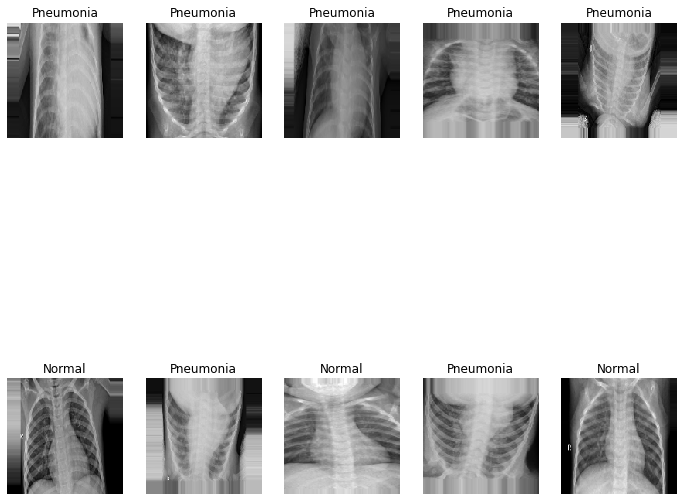

In [ ]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [ ]:
expert_conv = InceptionResNetV2(weights = 'imagenet', include_top = False,input_shape=(img_width, img_height, 3),input_tensor=None,pooling=None)

for layer in expert_conv.layers:
      trainable = True
      layer.trainable = trainable


expert_model = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model.add(expert_conv)
expert_model.add(GlobalAveragePooling2D())

expert_model.add(Dense(128, activation = 'relu'))
expert_model.add(Dropout(0.3))
expert_model.add(Dense(64, activation = 'relu'))
expert_model.add(Dense(1, activation = "sigmoid"))

opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

expert_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
expert_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 54,541,793
Trainable params: 54,481,249
Non-trainable params: 60,544
_______________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.514307 to fit



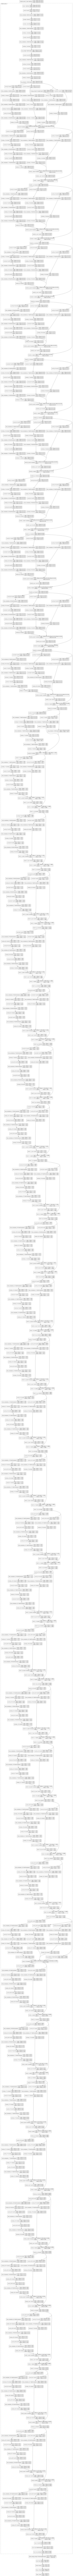

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(expert_model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [ ]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 2.0761054421768708, 1: 0.6586188292419747}


In [ ]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

expert_model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
257/257 [==============================] - 138s 352ms/step - loss: 0.6616 - accuracy: 0.4569 - val_loss: 0.4879 - val_accuracy: 0.7851
Epoch 2/25
257/257 [==============================] - 87s 339ms/step - loss: 0.4674 - accuracy: 0.8061 - val_loss: 0.4115 - val_accuracy: 0.8281
Epoch 3/25
257/257 [==============================] - 88s 341ms/step - loss: 0.2722 - accuracy: 0.8981 - val_loss: 0.3175 - val_accuracy: 0.8768
Epoch 4/25
257/257 [==============================] - 89s 344ms/step - loss: 0.2000 - accuracy: 0.9271 - val_loss: 0.2746 - val_accuracy: 0.8883
Epoch 5/25
257/257 [==============================] - 88s 343ms/step - loss: 0.1839 - accuracy: 0.9292 - val_loss: 0.4132 - val_accuracy: 0.8481
Epoch 6/25
257/257 [==============================] - 88s 343ms/step - loss: 0.1705 - accuracy: 0.9367 - val_loss: 0.1624 - val_accuracy: 0.9456
Epoch 7/25
257/257 [==============================] - 87s 338ms/step - loss: 0.1372 - accuracy: 0.9478 - val_loss: 0.2396 - val_a

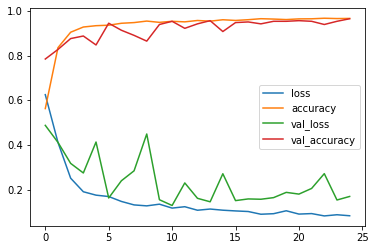

In [ ]:
pd.DataFrame(expert_model.history.history).plot()

In [ ]:
test_accu = expert_model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

33/33 [==============================] - 7s 222ms/step - loss: 0.1210 - accuracy: 0.9503
The testing accuracy is -  95.03205418586731 %


In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

y_bar = np.round(expert_model.predict(test)).reshape(-1)
y_act = test.labels

##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.9503205128205128
ROC-AUC score:  0.9513939366829562
F1 score:  0.9608091024020228
Log Loss:  1.715881513167522
